In [1]:
import warnings
import numpy as np

warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from process_text import sentiment_model
from process_text import clean_up_text
from process_text import preprocess
from process_text import string_cohesion


file_name = './sentiment140/training.1600000.processed.noemoticon.csv'
cols = ['sentiment','id','date','query_string','user','text']

#data = pd.read_csv(file_name,sep=',')
df=pd.read_csv(file_name,header=None, names=cols,encoding = "ISO-8859-1")
df=df.sample(frac=1)
df=df.reset_index(drop=True)

#df_pos = df[df['sentiment']==4]
#df_neu = df[df['sentiment']==2]
#df_neg = df[df['sentiment']==0]
#df.describe()
#print(len(df_pos),len(df_neu),len(df_neg), len(df))

df = df[0:20000]

print(df.head())

[nltk_data] Downloading package wordnet to /home/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/javier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
   sentiment          id                          date query_string  \
0          4  2002015232  Tue Jun 02 02:51:28 PDT 2009     NO_QUERY   
1          0  1881226044  Fri May 22 04:01:00 PDT 2009     NO_QUERY   
2          0  2175219696  Mon Jun 15 00:23:50 PDT 2009     NO_QUERY   
3          4  2175212637  Mon Jun 15 00:22:41 PDT 2009     NO_QUERY   
4          4  1827582647  Sun May 17 11:01:00 PDT 2009     NO_QUERY   

            user                                               text  
0  erlendforsund  @csavage Thanks for the advice! Yes, I'm looki...  
1    shads210309  can't play the guitar for a while, my fingers ...

In [2]:
df['text']= df['text'].apply(clean_up_text)

(array([ 9982.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10018.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

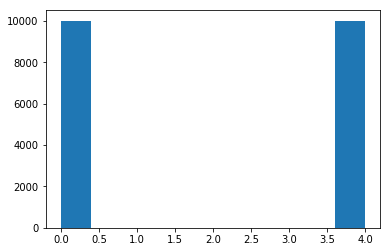

In [3]:
y = df['sentiment']

plt.hist(y)

In [4]:
df['text'][1]

'cant play guitar finger hu lot'

In [5]:
# Load in the sentiment models 

import warnings
warnings.filterwarnings('ignore')

from process_text import clean_up_text
from process_text import string_cohesion
from textblob import TextBlob
import spacy
import pickle
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

#--------------------------------------------------------------
# Import the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
#--------------------------------------------------------------


#--------------------------------------------------------------
# Import the vocabulary and generate the vectorizer transformer
#--------------------------------------------------------------
(A,terms,dict_sample) = joblib.load( "/home/javier/Documents/sentiment_analysis/sentiment_model/articles-raw.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
print('number of terms: ',len(terms))#print(dic_sample[0:10])
print('Dictionary: ',len(dict_sample))

vectorizer = TfidfVectorizer(stop_words = custom_stop_words,min_df = 20)
A = vectorizer.fit_transform(dict_sample)
print('A: ', A.shape)
#--------------------------------------------------------------


#--------------------------------------------------------------
# We load the trained models
#--------------------------------------------------------------
# The names of the files containing the weights of the model
filename1 = 'lr_sentiment_model.sav'
filename2 = 'nb_sentiment_model.sav'

# Now we load in the trained models
loaded_lr = pickle.load(open(filename1, 'rb'))
loaded_nb = pickle.load(open(filename2, 'rb'))

Loaded 3500 X 2444 document-term matrix
number of terms:  2444
Dictionary:  8750
A:  (8750, 2444)


In [16]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm


threshold = [0.2,0.4,0.6,0.8]
model_accuracy = []
model_sample_size = []


for t in threshold:
    
    sentiment_pred = []
    sentiment_prob = []
    y = []
    
    for k in tqdm(range(0,len(df))):
        # The Tweet to be analysed
        sample_text = df['text'][k]

        # The labelled sentiment of the tweet
        true_sentiment = df['sentiment'][k]

        # We map the sentiment to our values
        if(true_sentiment==0):
            y_true = -1
        elif(true_sentiment==4):
            y_true = +1

        pred,prob = sentiment_model(sample_text,t,vectorizer, loaded_lr,loaded_nb)

        if(pred!=0):
            y.append(y_true)
            sentiment_pred.append(pred)
            sentiment_prob.append(prob)
            
    acc = accuracy_score(y_pred=sentiment_pred,y_true=y)    
    model_accuracy.append(acc)
    model_sample_size.append(len(y))

100%|██████████| 20000/20000 [00:54<00:00, 365.04it/s]


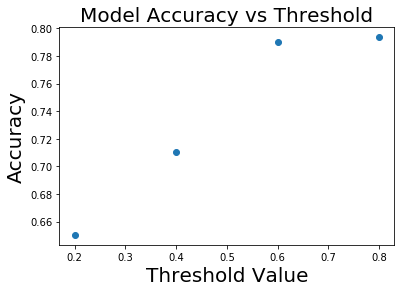

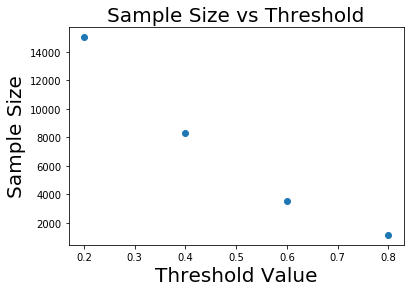

In [25]:
plt.plot(threshold,model_accuracy,'o')
plt.title('Model Accuracy vs Threshold',size=20)
plt.ylabel('Accuracy',size=20)
plt.xlabel('Threshold Value',size=20)
plt.show()


plt.plot(threshold,model_sample_size,'o')
plt.title('Sample Size vs Threshold',size=20)
plt.ylabel('Sample Size',size=20)
plt.xlabel('Threshold Value',size=20)
plt.show()